# GNN + Human Feedback (REINFORCE 방식) 추천 시스템 개발

# 1. 라이브러리 임포트

In [58]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch_geometric.data import HeteroData
from torch_geometric.nn import HANConv

# 2. GNN 모델 정의

In [59]:
class HAN_TravelRecommender(nn.Module):
    def __init__(self, metadata, hidden_dim=64, out_dim=2):
        super().__init__()
        self.han_conv = HANConv(-1, hidden_dim, metadata=metadata, heads=2)
        self.lin = nn.Linear(hidden_dim, out_dim)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.han_conv(x_dict, edge_index_dict)
        return self.lin(x_dict['visit_area'])  # 예측 결과: (만족도, 추천의향)

# 3. 데이터 구성

In [60]:
data_path = "../data/"  # 또는 './data/' 등 경로 조정

def load_tensor(name):
    return torch.tensor(np.load(os.path.join(data_path, name)), dtype=torch.float if 'features' in name else torch.long)

user_x = load_tensor("user_features.npy")
travel_x = load_tensor("travel_features.npy")
visit_x = load_tensor("visit_features.npy")
edge_user_travel = load_tensor("edge_user_to_travel.npy")
edge_travel_visit = load_tensor("edge_travel_to_visit.npy")

## 3-1. HeteroData 구성

In [61]:
hetero_data = HeteroData()
hetero_data['user'].x = user_x
hetero_data['travel'].x = travel_x
hetero_data['visit_area'].x = visit_x
hetero_data[('user', 'traveled', 'travel')].edge_index = edge_user_travel
hetero_data[('travel', 'contains', 'visit_area')].edge_index = edge_travel_visit

In [62]:
for fname in os.listdir(data_path):
    if fname.startswith("edge_visit_move_") and fname.endswith(".npy"):
        move_type = fname.replace("edge_visit_move_", "").replace(".npy", "")
        edge_index = load_tensor(fname)
        hetero_data[('visit_area', f'move_{move_type}', 'visit_area')].edge_index = edge_index

metadata = hetero_data.metadata()
metadata

(['user', 'travel', 'visit_area'],
 [('user', 'traveled', 'travel'),
  ('travel', 'contains', 'visit_area'),
  ('visit_area', 'move_16', 'visit_area'),
  ('visit_area', 'move_15', 'visit_area'),
  ('visit_area', 'move_14', 'visit_area'),
  ('visit_area', 'move_10', 'visit_area'),
  ('visit_area', 'move_11', 'visit_area'),
  ('visit_area', 'move_13', 'visit_area'),
  ('visit_area', 'move_12', 'visit_area'),
  ('visit_area', 'move_8', 'visit_area'),
  ('visit_area', 'move_9', 'visit_area'),
  ('visit_area', 'move_1', 'visit_area'),
  ('visit_area', 'move_2', 'visit_area'),
  ('visit_area', 'move_3', 'visit_area'),
  ('visit_area', 'move_7', 'visit_area'),
  ('visit_area', 'move_6', 'visit_area'),
  ('visit_area', 'move_4', 'visit_area'),
  ('visit_area', 'move_5', 'visit_area')])

# 4. 모델, 옵티마이저 초기화

In [63]:
model = HAN_TravelRecommender(metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5. GNN 출력 → softmax 확률 변환 → 샘플링

In [64]:
with torch.no_grad():
    out_before = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    top_before = torch.topk(out_before[:, 1], k=5)  # 추천의향 상위 5개
    print("추천 전 Top-5 장소 index:", top_before.indices.tolist())

추천 전 Top-5 장소 index: [1508, 1510, 1512, 1511, 1509]


In [65]:
model.eval()
with torch.no_grad():
    out = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    rcmdtn_scores = out[:, 1]
    probs = F.softmax(rcmdtn_scores, dim=0)

sampled_idx = torch.multinomial(probs, num_samples=1).item()
reward = -1.0  # 예시: 사용자가 해당 장소를 싫어함

In [66]:
model.train()
optimizer.zero_grad()
out = model(hetero_data.x_dict, hetero_data.edge_index_dict)
probs = F.softmax(out[:, 1], dim=0)
log_prob = torch.log(probs[sampled_idx])
loss = -log_prob * reward
loss.backward()
optimizer.step()

# 6. REINFORCE 손실 계산 후 파라미터 업데이트

In [67]:
# ✅ 9. GNN 추천 후 상태 확인
model.eval()
with torch.no_grad():
    out_after = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    top_after = torch.topk(out_after[:, 1], k=5)
    print("추천 후 Top-5 장소 index:", top_after.indices.tolist())

# ✅ 10. 샘플 정보 출력
print("샘플링된 장소 index:", sampled_idx)
print("샘플링 확률:", round(probs[sampled_idx].item(), 4))
print("보상 (reward):", reward)
print("REINFORCE loss:", round(loss.item(), 4))

추천 후 Top-5 장소 index: [1509, 1510, 1512, 1511, 1508]
샘플링된 장소 index: 12005
샘플링 확률: 0.0001
보상 (reward): -1.0
REINFORCE loss: -9.6156


[정책 이전] 추천 Top-5 장소 index: [503, 535, 1233, 521, 517]
싫다고 한 것 :  [1233]
[정책 이후] 추천 Top-5 장소 index: [1508, 1509, 1512, 1511, 1510]


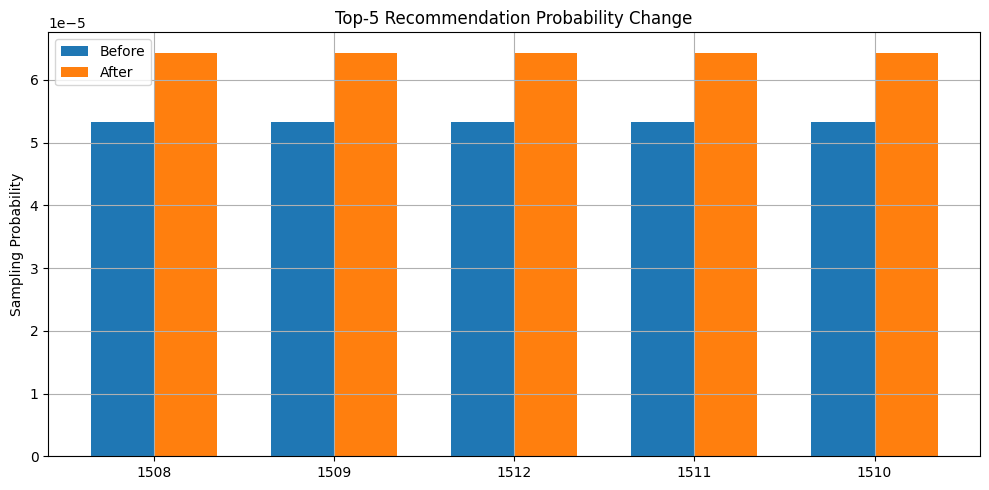

In [68]:
# GNN + Human Feedback (정책 네트워크 기반 강화학습) 추천 시스템 템플릿

# ✅ 1. 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch_geometric.data import HeteroData
from torch_geometric.nn import HANConv
import os

# ✅ 2. 정책 네트워크 포함 GNN 모델 정의
class HANPolicyRecommender(nn.Module):
    def __init__(self, metadata, hidden_dim=64):
        super().__init__()
        self.han_conv = HANConv(-1, hidden_dim, metadata=metadata, heads=2)
        self.policy_head = nn.Linear(hidden_dim, 1)  # 추천 확률 출력

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.han_conv(x_dict, edge_index_dict)
        return self.policy_head(x_dict['visit_area']).squeeze(-1)  # [num_visit_area]


# ✅ 3. 데이터 로드 (.npy 기반 실제 전처리 데이터 사용)
data_path = "../data/"

def load_tensor(name):
    return torch.tensor(np.load(os.path.join(data_path, name)), dtype=torch.float if 'features' in name else torch.long)

user_x = load_tensor("user_features.npy")
travel_x = load_tensor("travel_features.npy")
visit_x = load_tensor("visit_features.npy")
edge_user_travel = load_tensor("edge_user_to_travel.npy")
edge_travel_visit = load_tensor("edge_travel_to_visit.npy")

# ✅ 4. HeteroData 구성
hetero_data = HeteroData()
hetero_data['user'].x = user_x
hetero_data['travel'].x = travel_x
hetero_data['visit_area'].x = visit_x
hetero_data[('user', 'traveled', 'travel')].edge_index = edge_user_travel
hetero_data[('travel', 'contains', 'visit_area')].edge_index = edge_travel_visit

for fname in os.listdir(data_path):
    if fname.startswith("edge_visit_move_") and fname.endswith(".npy"):
        move_type = fname.replace("edge_visit_move_", "").replace(".npy", "")
        edge_index = load_tensor(fname)
        hetero_data[('visit_area', f'move_{move_type}', 'visit_area')].edge_index = edge_index

metadata = hetero_data.metadata()

# ✅ 5. 정책 GNN 초기화
model = HANPolicyRecommender(metadata)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ✅ 6. GNN 출력 → softmax 확률로 정책 구성
model.eval()
with torch.no_grad():
    logits_before = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    temperature = 2.0  # softmax 분포를 완화하기 위한 온도 파라미터
    probs_before = F.softmax(logits_before / temperature, dim=0)
    top_before = torch.topk(probs_before, k=5)
    print("[정책 이전] 추천 Top-5 장소 index:", top_before.indices.tolist())

# ✅ 7. 사용자 피드백 반영한 샘플 학습 (예: 유저가 512, 28 싫어함)
feedback_indices = top_before.indices.tolist()[2:3]  # 유저가 싫어한 추천 장소 인덱스
reward = -1.0  # 부정적 피드백

print("싫다고 한 것 : ", feedback_indices)
for idx in feedback_indices:
    for step in range(10):
        model.train()
        optimizer.zero_grad()
        logits = model(hetero_data.x_dict, hetero_data.edge_index_dict)
        probs = F.softmax(logits / temperature, dim=0)
        log_prob = torch.log(probs[idx])
        loss = -log_prob * reward
        loss.backward()
        optimizer.step()

# ✅ 8. GNN 추천 후 상태 확인
model.eval()
with torch.no_grad():
    logits_after = model(hetero_data.x_dict, hetero_data.edge_index_dict)
    probs_after = F.softmax(logits_after / temperature, dim=0)
    top_after = torch.topk(probs_after, k=5)
    print("[정책 이후] 추천 Top-5 장소 index:", top_after.indices.tolist())

# ✅ 9. 추천 확률 분포 시각화
import matplotlib.pyplot as plt

indices = top_after.indices.tolist()
labels = [f"{i}" for i in indices]
before_vals = [probs_before[i].item() for i in indices]
after_vals = [probs_after[i].item() for i in indices]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, before_vals, width, label='Before')
ax.bar(x + width/2, after_vals, width, label='After')

ax.set_ylabel('Sampling Probability')  # Y축: 샘플링 확률
ax.set_title('Top-5 Recommendation Probability Change')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()  # 범례 표시
plt.grid(True)
plt.tight_layout()
plt.show()
